In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: install tim

from google.colab import drive

drive.mount('/content/drive')

!pip install timm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
from torch.cuda.amp import GradScaler, autocast
import timm

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a common size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
test_dataset = AccidentDataset(data_dir + 'test', transform=transform)

# Use 20% of the dataset for training
train_size = int(0.2 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])

# DataLoaders with Reduced Batch Size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the Swin Transformer Model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

# Modify the model's head for binary classification
class CustomSwinHead(nn.Module):
    def __init__(self, in_features):
        super(CustomSwinHead, self).__init__()
        self.flatten = nn.Flatten()  # Flatten the 7x7 spatial dimensions
        self.fc = nn.Linear(in_features * 49, 1)  # Adjusted to match the flattened size

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Replace the model's head with the custom head
model.head = CustomSwinHead(model.head.in_features)

model = model.to(device)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
scaler = GradScaler()

# Training, Validation, and Testing
num_epochs = 5
history_swin = {
    'train_losses': [],
    'val_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'test_accuracies': [],
}

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    history_swin['train_losses'].append(running_loss / len(train_loader))
    history_swin['train_accuracies'].append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    history_swin['val_losses'].append(val_running_loss / len(val_loader))
    history_swin['val_accuracies'].append(val_correct / len(val_loader.dataset))

    # Testing after each epoch
    test_running_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            test_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            test_correct += (preds == labels).sum().item()

    history_swin['test_losses'].append(test_running_loss / len(test_loader))
    history_swin['test_accuracies'].append(test_correct / len(test_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {history_swin["train_losses"][-1]:.4f}, Val Loss: {history_swin["val_losses"][-1]:.4f}, Test Loss: {history_swin["test_losses"][-1]:.4f}, Train Acc: {history_swin["train_accuracies"][-1]:.4f}, Val Acc: {history_swin["val_accuracies"][-1]:.4f}, Test Acc: {history_swin["test_accuracies"][-1]:.4f}')

    scheduler.step()

# Save the model and history
model_path = f'/content/drive/MyDrive/swin_transformer_finetuned.pth'
torch.save(model.state_dict(), model_path)

history_path = f'/content/drive/MyDrive/swin_transformer_history.pth'
torch.save(history_swin, history_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/5, Train Loss: 2.0565, Val Loss: 2.0363, Test Loss: 1.6413, Train Acc: 0.4367, Val Acc: 0.4694, Test Acc: 0.4700
Epoch 2/5, Train Loss: 0.9539, Val Loss: 0.7413, Test Loss: 0.7129, Train Acc: 0.5696, Val Acc: 0.4694, Test Acc: 0.4700
Epoch 3/5, Train Loss: 0.7911, Val Loss: 0.7584, Test Loss: 0.7528, Train Acc: 0.4430, Val Acc: 0.5306, Test Acc: 0.5300
Epoch 4/5, Train Loss: 0.7077, Val Loss: 0.6993, Test Loss: 0.6980, Train Acc: 0.4873, Val Acc: 0.5306, Test Acc: 0.5300
Epoch 5/5, Train Loss: 0.6998, Val Loss: 0.6841, Test Loss: 0.6980, Train Acc: 0.5316, Val Acc: 0.5306, Test Acc: 0.5300


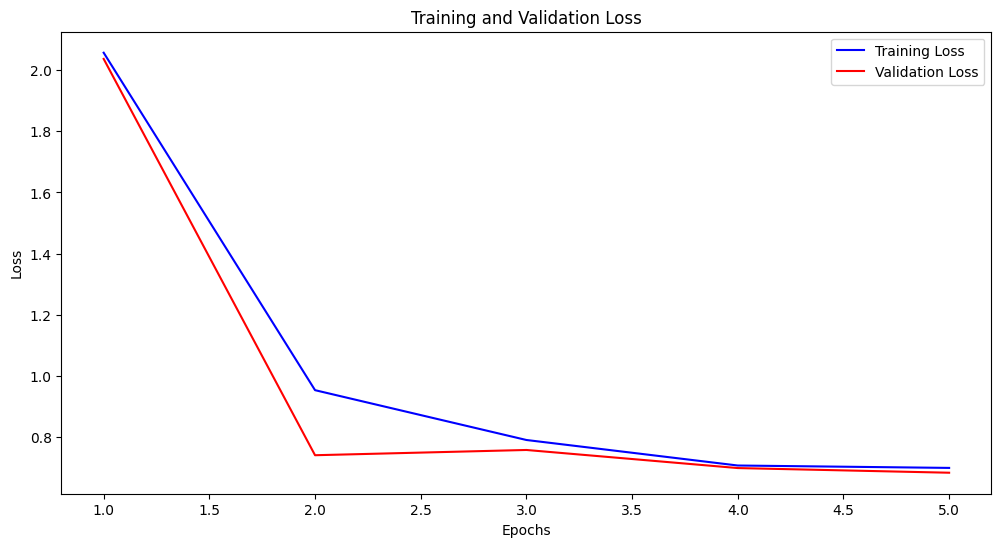

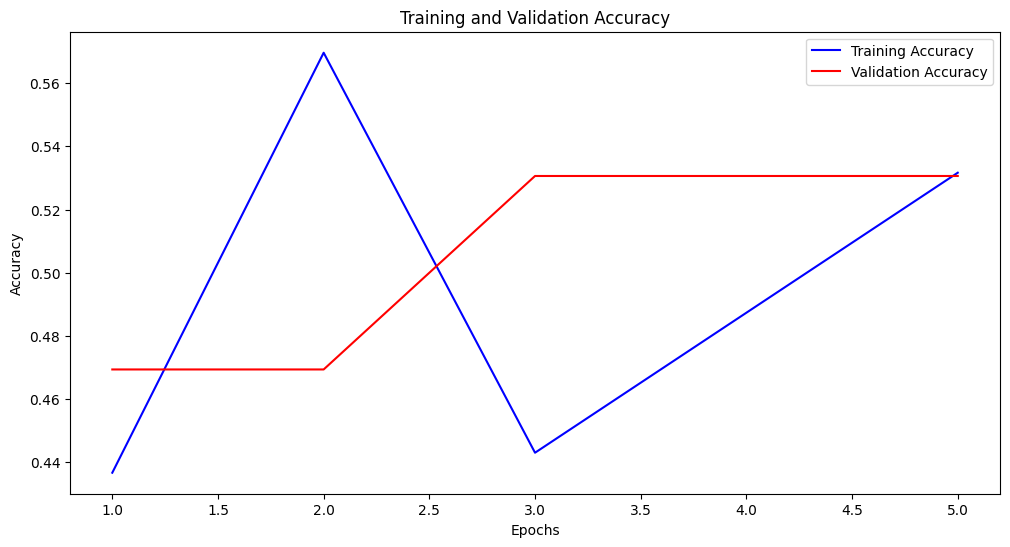

<Figure size 1500x500 with 0 Axes>

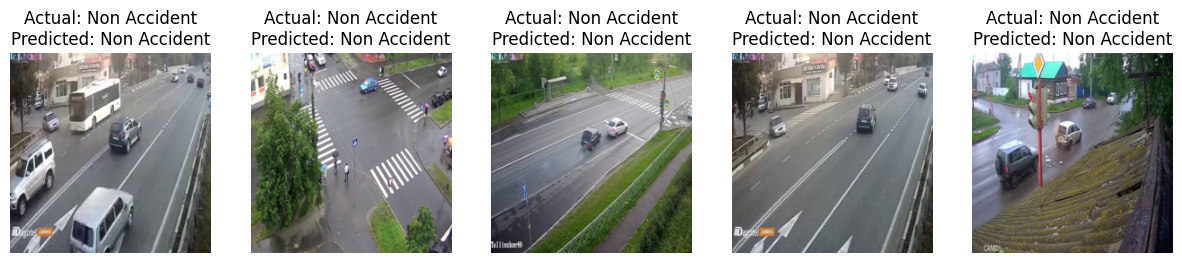

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:
               precision    recall  f1-score   support

Non Accident       0.53      1.00      0.69        52
    Accident       0.00      0.00      0.00        46

    accuracy                           0.53        98
   macro avg       0.27      0.50      0.35        98
weighted avg       0.28      0.53      0.37        98



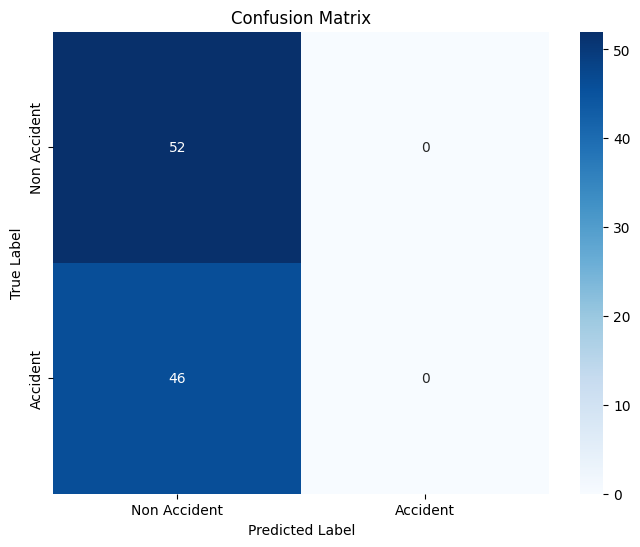

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the training history
history_path = f'/content/drive/MyDrive/swin_transformer_history.pth'
history_swin = torch.load(history_path)

# Plotting Accuracy and Loss Graphs
def plot_metrics(history):
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_losses'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_losses'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_accuracies'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history_swin)

# Visualize Predictions on the Validation Set
def visualize_predictions(model, val_loader, num_images=5):
    model.eval()
    accident_images = []
    non_accident_images = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(preds)):
                # Collect correctly predicted accident images
                if preds[i] == 1 and labels[i] == 1 and len(accident_images) < num_images:
                    accident_images.append((inputs[i].cpu(), labels[i], preds[i]))
                # Collect correctly predicted non-accident images
                elif preds[i] == 0 and labels[i] == 0 and len(non_accident_images) < num_images:
                    non_accident_images.append((inputs[i].cpu(), labels[i], preds[i]))

                # Stop if we have enough images
                if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                    break
            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    # Plot Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Accident\nPredicted: Accident')
        plt.axis('off')
    plt.show()

    # Plot Non-Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Non Accident\nPredicted: Non Accident')
        plt.axis('off')
    plt.show()

# Load the trained model
model_path = f'/content/drive/MyDrive/swin_transformer_finetuned.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)

# Visualize predictions
visualize_predictions(model, val_loader, num_images=5)

# Classification Report and Confusion Matrix
def generate_classification_report_and_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident'], output_dict=True)
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident']))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

generate_classification_report_and_confusion_matrix(model, val_loader)


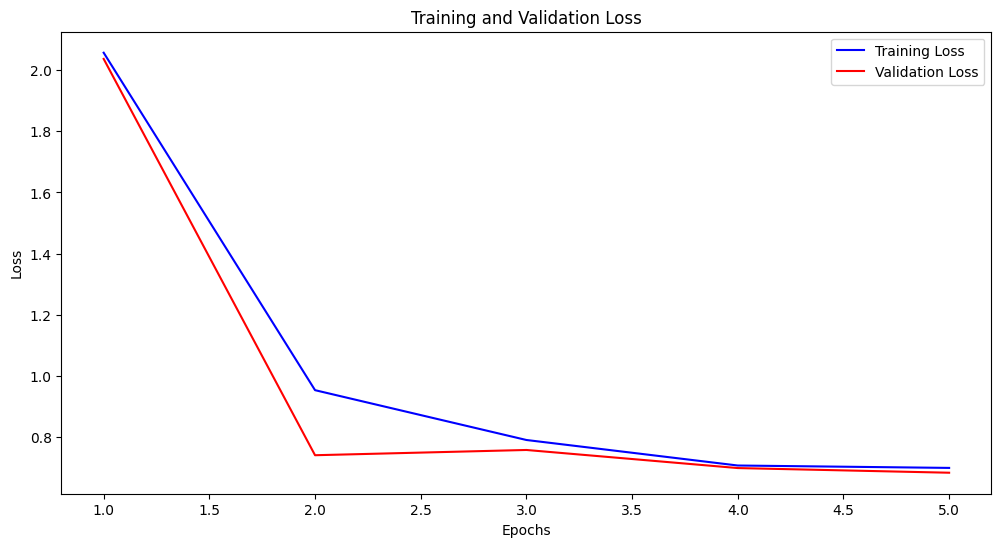

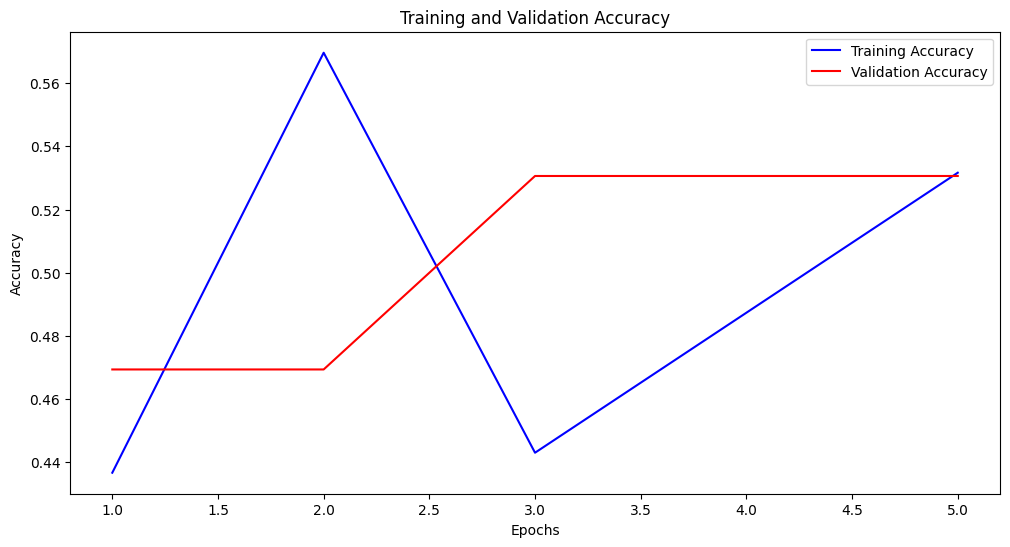

<Figure size 1500x500 with 0 Axes>

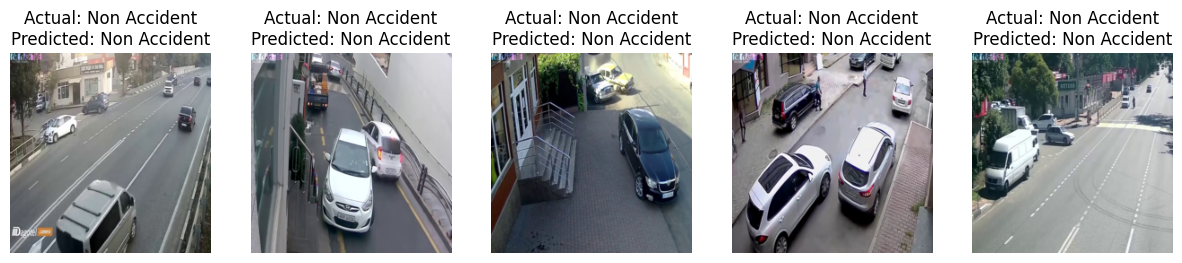

Predicted Class Distribution: [98]

Classification Report:
               precision    recall  f1-score   support

Non Accident       0.53      1.00      0.69        52
    Accident       0.00      0.00      0.00        46

    accuracy                           0.53        98
   macro avg       0.27      0.50      0.35        98
weighted avg       0.28      0.53      0.37        98



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


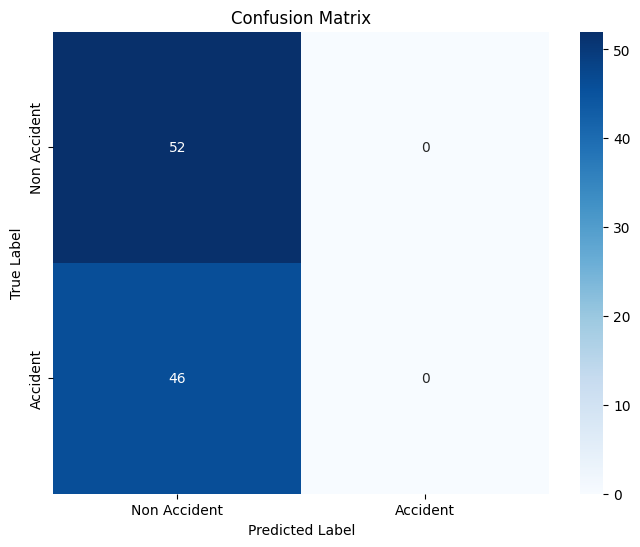

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the training history
history_path = f'/content/drive/MyDrive/swin_transformer_history.pth'
history_swin = torch.load(history_path)

# Plotting Accuracy and Loss Graphs
def plot_metrics(history):
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_losses'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_losses'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_accuracies'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history_swin)

# Visualize Predictions on the Validation Set
def visualize_predictions(model, val_loader, num_images=5):
    model.eval()
    accident_images = []
    non_accident_images = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(preds)):
                # Collect correctly predicted accident images
                if preds[i] == 1 and labels[i] == 1 and len(accident_images) < num_images:
                    accident_images.append((inputs[i].cpu(), labels[i], preds[i]))
                # Collect correctly predicted non-accident images
                elif preds[i] == 0 and labels[i] == 0 and len(non_accident_images) < num_images:
                    non_accident_images.append((inputs[i].cpu(), labels[i], preds[i]))

                # Stop if we have enough images
                if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                    break
            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    # Plot Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Accident\nPredicted: Accident')
        plt.axis('off')
    plt.show()

    # Plot Non-Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Non Accident\nPredicted: Non Accident')
        plt.axis('off')
    plt.show()

# Load the trained model
model_path = f'/content/drive/MyDrive/swin_transformer_finetuned.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)

# Visualize predictions
visualize_predictions(model, val_loader, num_images=5)

# Classification Report and Confusion Matrix
def generate_classification_report_and_confusion_matrix(model, val_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = (torch.sigmoid(outputs) > threshold).cpu().numpy()  # Apply threshold
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Convert predictions and labels to integers
    all_preds = np.array(all_preds).astype(int)
    all_labels = np.array(all_labels).astype(int)

    # Check the distribution of predictions
    print("Predicted Class Distribution:", np.bincount(all_preds))

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident'])
    print("\nClassification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Generate classification report and confusion matrix
generate_classification_report_and_confusion_matrix(model, val_loader)
